# Model Testing's Notebook

## Library Import

**Penjelasan tahapan** : Tahapan ini dilakukan untuk mengambil library yang dibutuhkan untuk menjalankan semua code yang terdapat dalam file notebook (.ipynb) ini. Penjelasan mengenai fungsi masing-masing library yang di-import dapat dibaca pada baris code.

In [1]:
import requests # Mengimpor Library Requests untuk Mengirim Permintaan HTTP ke Server
import json # Mengimpor Library JSON untuk Bekerja dengan Data JSON
import numpy as np # Mengimpor Library NumPy untuk Operasi Array Numerik
from PIL import Image # Mengimpor Modul Image dari Library PIL (Pillow) untuk Membaca dan Memanipulasi Gambar
import matplotlib.pyplot as plt # Mengimpor Matplotlib.pyplot untuk Menampilkan Gambar dan Plot

## Set Prediction EndPoint

**Penjelasan tahapan** : Pada tahap pertama pengujian melalui notebook, langkah yang dilakukan adalah mendefinisikan endpoint prediksi dari model yang telah berhasil dipush oleh komponen Pusher. Di sini, sebuah variabel MODEL_NAME diatur dengan nama model yang ingin dipanggil, misalnya "weather_classification", kemudian disusun URL endpoint sesuai format standar TensorFlow Serving yang berjalan pada port default 8501. URL tersebut mengarah ke alamat http://localhost:8501/v1/models/{MODEL_NAME}:predict, yang akan menjadi pintu masuk untuk mengirimkan request prediksi ke model. Terakhir, URL yang dihasilkan dicetak ke layar untuk memastikan endpoint sudah terbentuk dengan benar sebelum dipakai dalam pengujian lebih lanjut.

In [2]:
MODEL_NAME = "weather_classification" # Mendefinisikan Nama Model yang Akan Dipanggil
URL = f"http://localhost:8501/v1/models/{MODEL_NAME}:predict" # Membangun URL Endpoint Prediksi Server TensorFlow Serving
print("Serving endpoint:", URL) # Mencetak URL Endpoint untuk Verifikasi

Serving endpoint: http://localhost:8501/v1/models/weather_classification:predict


## Preparing Test Image

**Penjelasan tahapan** : Pada tahap kedua ini dilakukan persiapan gambar uji yang akan digunakan untuk menguji model yang sudah di-deploy. Pertama, path gambar uji didefinisikan, kemudian gambar dibuka menggunakan PIL dan dikonversi ke format RGB agar konsisten dengan input yang diharapkan model. Setelah itu gambar diubah ukurannya sesuai dengan IMG_SIZE yang ditetapkan sebelumnya, lalu hasilnya dikonversi menjadi array NumPy dengan nilai piksel dinormalisasi ke rentang 0–1. Karena model membutuhkan input dengan format batch, ditambahkan satu dimensi ekstra pada array gambar menggunakan np.expand_dims. Terakhir, gambar yang sudah diproses ditampilkan dengan Matplotlib agar bisa diverifikasi secara visual sebelum digunakan dalam request prediksi ke model.

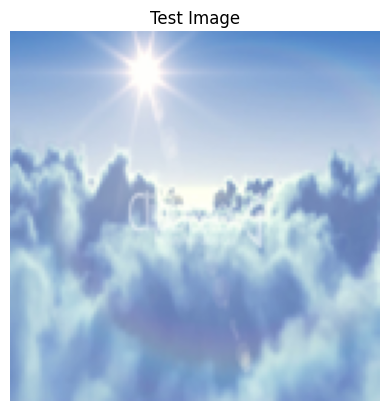

In [3]:
img_path = "testing_image.jpg" # Menentukan Path ke File Gambar yang Akan Diuji
 
IMG_SIZE = (128, 128) # Mendefinisikan Ukuran Gambar yang Disesuaikan (Resize)
img = Image.open(img_path).convert("RGB") # Membuka Gambar dari Path yang Diberikan dan Mengubahnya ke Format RGB
img_resized = img.resize(IMG_SIZE) # Mengubah Ukuran Gambar Sesuai dengan IMG_SIZE
 
img_array = np.array(img_resized) / 255.0 # Mengubah Gambar yang Sudah Disesuaikan Menjadi Array NumPy dan Menormalisasikan Nilai Pikselnya
input_data = np.expand_dims(img_array, axis=0) # Menambahkan Dimensi Batch ke Array Gambar untuk Sesuai dengan Format Input Model
 
plt.imshow(img_resized) # Menampilkan Gambar yang Sudah Disesuaikan Menggunakan Matplotlib
plt.title("Test Image") # Memberikan Judul pada Plot Gambar
plt.axis("off") # Menyembunyikan Axis (Sumbu) pada Plot
plt.show() # Menampilkan Plot

## Make Payload Request

**Penjelasan tahapan** : Pada tahap ketiga ini dibuat sebuah payload request yang akan dikirimkan ke endpoint model TensorFlow Serving. Data gambar yang sebelumnya sudah diproses diubah dari array NumPy menjadi list Python agar kompatibel dengan format JSON, lalu dimasukkan ke dalam dictionary dengan kunci "instances" sesuai standar TensorFlow Serving. Payload ini kemudian dikirim melalui permintaan POST menggunakan library requests ke URL endpoint yang telah ditentukan. Setelah request dikirim, kode status HTTP dari respons dicetak untuk memastikan bahwa server menerima permintaan dengan benar. Selanjutnya respons dalam format JSON diambil, lalu ditampilkan kembali dalam format yang rapi agar hasil prediksi model mudah dibaca dan diverifikasi.

In [4]:
payload = { # Membuat Payload (Permintaan) Berupa Dictionary
    "instances": input_data.tolist() # Mengonversi Array NumPy Input ke List Python untuk Dikirim dalam Format JSON
}
 
response = requests.post(URL, json=payload) # Mengirim Permintaan POST ke URL Endpoint dengan Payload JSON
print("Status Code:", response.status_code) # Mencetak Kode Status dari Respons HTTP
 
result = response.json() # Mengambil Respons JSON dari Server
print(json.dumps(result, indent=2)) # Mencetak Hasil Prediksi dalam Format JSON yang Terformat Rapi

Status Code: 200
{
  "predictions": [
    [
      0.0402716063,
      0.000288955896,
      0.957981706,
      0.00145772705
    ]
  ]
}


## Prediction Mapping

**Penjelasan tahapan** : Tahap terakhir ini adalah melakukan mapping hasil prediksi ke dalam label kelas yang sesuai. Array hasil prediksi yang dikembalikan oleh model diambil dari respons JSON dan diubah menjadi array NumPy untuk mempermudah proses pengolahan. Nilai probabilitas dari setiap kelas kemudian diperiksa, dan kelas dengan nilai probabilitas tertinggi ditentukan sebagai hasil prediksi. Nama kelas tersebut diambil dari daftar CLASS_NAMES yang telah ditentukan sebelumnya sehingga output prediksi dapat langsung ditampilkan dalam bentuk label yang mudah dipahami. Pada tahap ini juga ditampilkan nilai probabilitas prediksi lengkap, label hasil prediksi, serta ground truth untuk gambar uji agar memudahkan perbandingan antara hasil model dengan label sebenarnya.

In [7]:
CLASS_NAMES = ["Cloudy", "Rain", "Shine", "Sunrise"] # Mendefinisikan Nama-nama Kelas yang Sesuai dengan Urutan di Model
predictions = np.array(result["predictions"])[0] # Mengambil Array Prediksi dari Hasil Respons
pred_class = CLASS_NAMES[np.argmax(predictions)] # Menentukan Kelas Prediksi dengan Mengambil Indeks dengan Nilai Probabilitas Tertinggi
 
print("Predictions:", predictions) # Mencetak Array Probabilitas Prediksi
print("Predicted class:", pred_class) # Mencetak Nama Kelas yang Diprediksi
print("Groundtruth: Shine") # Mencetak Kebenaran Sebenarnya (Ground Truth) dari Gambar

Predictions: [4.02716063e-02 2.88955896e-04 9.57981706e-01 1.45772705e-03]
Predicted class: Shine
Groundtruth: Shine
